# Trabalho 2 - Introdução à Ciência de Dados

### Dupla: Larissa Lewartoski Wong

## Dataset escolhido: Diabetes

In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from fancyimpute import IterativeImputer

## Carregando o dataset

#### A variável header nomeia as colunas

#### Os parâmetros passados para a função read_csv incluem:
* comment='@' - para ignorar as linhas que se iniciam com @
* skiprows - para ignorar as linhas anteriores à 84 (foi observado no arquivo arff que os dados começam após essas linhas)

In [92]:
header = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']
diabetes = pd.read_csv('dataset_37_diabetes.arff', comment='@', skiprows=84, header=None, na_values=['?'], names=header)

In [93]:
diabetes

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


## Convertendo Nominais em Numéricos

* Testes positivos serão convertidos em 1
* Testes negativos em 0 

In [94]:
diabetes['class'] = [0 if x == 'tested_negative' else 1 for x in diabetes['class']]
diabetes_default = diabetes.copy()

## Tratando valores ausentes

#### Observou-se que os valores ausentes estão representados como 0 em alguns atributos como insulina

In [95]:
colunas_substituir = ['plas', 'pres', 'skin', 'insu', 'mass', 'pedi']
diabetes[colunas_substituir] = diabetes[colunas_substituir].replace(0, np.nan)

### Utilizando MICE para completar os atributos faltantes

In [97]:
imputer = IterativeImputer()

diabetes_imputado = imputer.fit_transform(diabetes)
diabetes_imputado = pd.DataFrame(diabetes_imputado, columns=diabetes.columns)

## Normalizando os dados

In [98]:
scaler = MinMaxScaler()
diabetes_norm = pd.DataFrame(scaler.fit_transform(diabetes_default), columns= diabetes_default.columns)
diabetes_norm_mice = pd.DataFrame(scaler.fit_transform(diabetes_imputado), columns = diabetes_imputado.columns)

## Verificando a distribuição de classes

* Com base na distribuição de classes obtida foi escolhido não realizar o balanceamento

Negatives: 500 | Positives: 268


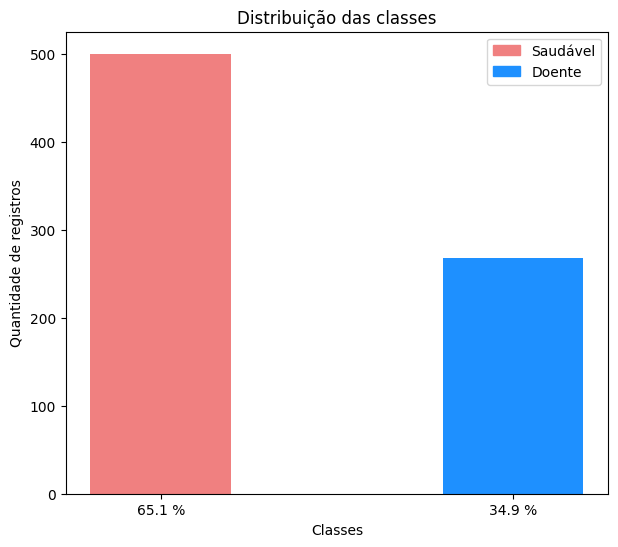

In [99]:
zero = diabetes_norm[diabetes_norm['class'] == 0]['class'].size
one = diabetes_norm[diabetes_norm['class'] == 1]['class'].size

size = diabetes_norm['class'].size
zero_label = str(round(zero*100/diabetes_norm['class'].size, 2)) + " %"
one_label = str(round(one*100/diabetes_norm['class'].size, 2)) + " %"

print('Negatives: {} | Positives: {}'.format(zero, one))
fig = plt.figure(figsize = (7, 6))
plt.bar([zero_label,one_label], [zero, one], color =['lightcoral', 'dodgerblue'],
        width = 0.4)
plt.xlabel("Classes")
plt.ylabel("Quantidade de registros")
plt.title("Distribuição das classes")
colors = {'Saudável':'lightcoral', 'Doente':'dodgerblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

## Separando o dataset em 10 folds

* Serão geradas 10 partes iguais para realização de comparação posterior

In [100]:
kf = KFold(n_splits=10)

# Classificador default

* Para o classificador default foram utilizados os parâmetros definidos na especificação do trabalho:
    - K = 3
    - Distância Euclideana

As etapas de pré processamento para aplicação do KNN foram realizadas acima (normalização e conversão para atributos numéricos)

In [101]:
knn_default = KNeighborsClassifier(n_neighbors=3, metric='euclidean')

X_default = diabetes_norm.drop(['class'], axis=1)
y_default = diabetes_norm['class']

## Acurácia para o default utilizando 10-fold cross validation

- KNN sem mice com k=3 e distância euclideana

In [104]:
acuracia_default_sem_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_default.fit(X_train, y_train)
    
    y_pred1 = knn_default.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_default_sem_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_default_sem_mice = sum(acuracia_default_sem_mice) / len(acuracia_default_sem_mice) * 100


print("Acurácia média do default: {:.2f}%".format(acuracia_media_default_sem_mice))


Fold 0: 67.53%
Fold 1: 83.12%
Fold 2: 71.43%
Fold 3: 72.73%
Fold 4: 70.13%
Fold 5: 74.03%
Fold 6: 76.62%
Fold 7: 83.12%
Fold 8: 69.74%
Fold 9: 76.32%
Acurácia média do default: 74.48%


# Modelo sugerido

### Para desenvolvimento do modelo sugerido foram testados valores de k: 3, 5, 7, 9 e 11 para verificar se alterar o valor poderia ser uma opção viável de melhoria do modelo mantendo a distância euclideana

In [105]:
X_mice = diabetes_norm_mice.drop(['class'], axis=1)
y_mice = diabetes_norm_mice['class']

## Testes sem MICE

### Variando o número de vizinhos

### Com peso uniforme no KNN

#### Teste 1 n=5

In [116]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

acuracia_n5 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5) / len(acuracia_n5) * 100


print("Acurácia média n5: {:.2f}%".format(acuracia_media_n5))

Fold 0: 66.23%
Fold 1: 85.71%
Fold 2: 67.53%
Fold 3: 70.13%
Fold 4: 77.92%
Fold 5: 71.43%
Fold 6: 76.62%
Fold 7: 83.12%
Fold 8: 72.37%
Fold 9: 73.68%
Acurácia média n5: 74.48%


#### Teste 2 n=7

In [117]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='uniform')

acuracia_n7 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7) / len(acuracia_n7) * 100


print("Acurácia média n7: {:.2f}%".format(acuracia_media_n7))

Fold 0: 67.53%
Fold 1: 87.01%
Fold 2: 67.53%
Fold 3: 68.83%
Fold 4: 79.22%
Fold 5: 75.32%
Fold 6: 75.32%
Fold 7: 81.82%
Fold 8: 75.00%
Fold 9: 75.00%
Acurácia média n7: 75.26%


#### Teste 3 n=9

In [118]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='uniform')

acuracia_n9 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9) / len(acuracia_n9) * 100


print("Acurácia média n9: {:.2f}%".format(acuracia_media_n9))

Fold 0: 67.53%
Fold 1: 81.82%
Fold 2: 68.83%
Fold 3: 67.53%
Fold 4: 79.22%
Fold 5: 74.03%
Fold 6: 74.03%
Fold 7: 83.12%
Fold 8: 75.00%
Fold 9: 76.32%
Acurácia média n9: 74.74%


#### Teste 4 n=11

In [119]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')

acuracia_n11 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11) / len(acuracia_n11) * 100


print("Acurácia média n11: {:.2f}%".format(acuracia_media_n11))

Fold 0: 64.94%
Fold 1: 84.42%
Fold 2: 67.53%
Fold 3: 70.13%
Fold 4: 77.92%
Fold 5: 75.32%
Fold 6: 76.62%
Fold 7: 80.52%
Fold 8: 73.68%
Fold 9: 75.00%
Acurácia média n11: 74.61%


### Variando o número de vizinhos

### Com peso inversamente proporcional à distância dos vizinhos

#### Teste 1 n=3

In [120]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance')

acuracia_n3 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n3.fit(X_train, y_train)
    
    y_pred1 = knn_n3.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n3.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n3 = sum(acuracia_n3) / len(acuracia_n3) * 100


print("Acurácia média n5: {:.2f}%".format(acuracia_media_n3))

Fold 0: 67.53%
Fold 1: 81.82%
Fold 2: 71.43%
Fold 3: 72.73%
Fold 4: 70.13%
Fold 5: 72.73%
Fold 6: 76.62%
Fold 7: 83.12%
Fold 8: 69.74%
Fold 9: 77.63%
Acurácia média n5: 74.35%


#### Teste 2 n=5

In [122]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

acuracia_n5 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5) / len(acuracia_n5) * 100

print("Acurácia média n5: {:.2f}%".format(acuracia_media_n5))

Fold 0: 66.23%
Fold 1: 84.42%
Fold 2: 66.23%
Fold 3: 70.13%
Fold 4: 77.92%
Fold 5: 71.43%
Fold 6: 76.62%
Fold 7: 81.82%
Fold 8: 72.37%
Fold 9: 75.00%
Acurácia média n5: 74.22%


#### Teste 3 n=7

In [123]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='distance')

acuracia_n7 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7) / len(acuracia_n7) * 100


print("Acurácia média n7: {:.2f}%".format(acuracia_media_n7))

Fold 0: 67.53%
Fold 1: 85.71%
Fold 2: 64.94%
Fold 3: 68.83%
Fold 4: 79.22%
Fold 5: 75.32%
Fold 6: 76.62%
Fold 7: 81.82%
Fold 8: 75.00%
Fold 9: 75.00%
Acurácia média n7: 75.00%


#### Teste 4 n=9

In [124]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='distance')

acuracia_n9 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9) / len(acuracia_n9) * 100


print("Acurácia média n9: {:.2f}%".format(acuracia_media_n9))

Fold 0: 68.83%
Fold 1: 84.42%
Fold 2: 66.23%
Fold 3: 67.53%
Fold 4: 80.52%
Fold 5: 72.73%
Fold 6: 76.62%
Fold 7: 83.12%
Fold 8: 75.00%
Fold 9: 76.32%
Acurácia média n9: 75.13%


#### Teste 5 n=11

In [125]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='distance')

acuracia_n11 = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11) / len(acuracia_n11) * 100


print("Acurácia média n11: {:.2f}%".format(acuracia_media_n11))

Fold 0: 64.94%
Fold 1: 85.71%
Fold 2: 66.23%
Fold 3: 70.13%
Fold 4: 80.52%
Fold 5: 74.03%
Fold 6: 77.92%
Fold 7: 80.52%
Fold 8: 73.68%
Fold 9: 76.32%
Acurácia média n11: 75.00%


### Variando a medida de distância

## Testes com MICE

### Variando o número de vizinhos 
### Com peso uniforme no KNN

#### Teste 1 n=3

In [136]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='uniform')

acuracia_n3 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n3.fit(X_train, y_train)
    
    y_pred1 = knn_n3.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n3.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n3 = sum(acuracia_n3) / len(acuracia_n3) * 100


print("Acurácia média n3 utilizando mice: {:.2f}%".format(acuracia_media_n3))

Fold 0: 71.43%
Fold 1: 79.22%
Fold 2: 71.43%
Fold 3: 70.13%
Fold 4: 75.32%
Fold 5: 72.73%
Fold 6: 72.73%
Fold 7: 81.82%
Fold 8: 65.79%
Fold 9: 73.68%
Acurácia média n3 utilizando mice: 73.43%


#### Teste 2 n=5

In [137]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

acuracia_n5 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5) / len(acuracia_n5) * 100


print("Acurácia média n5 utilizando mice: {:.2f}%".format(acuracia_media_n5))

Fold 0: 68.83%
Fold 1: 84.42%
Fold 2: 76.62%
Fold 3: 66.23%
Fold 4: 74.03%
Fold 5: 74.03%
Fold 6: 79.22%
Fold 7: 84.42%
Fold 8: 72.37%
Fold 9: 76.32%
Acurácia média n5 utilizando mice: 75.65%


#### Teste 3 n=7

In [133]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='uniform')

acuracia_n7 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7) / len(acuracia_n7) * 100


print("Acurácia média n7 utilizando mice: {:.2f}%".format(acuracia_media_n7))

Fold 0: 67.53%
Fold 1: 84.42%
Fold 2: 77.92%
Fold 3: 66.23%
Fold 4: 80.52%
Fold 5: 74.03%
Fold 6: 76.62%
Fold 7: 84.42%
Fold 8: 72.37%
Fold 9: 76.32%
Acurácia média n7 utilizando mice: 76.04%


#### Teste 4 n=9

In [131]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='uniform')

acuracia_n9 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9) / len(acuracia_n9) * 100


print("Acurácia média n9 utilizando mice: {:.2f}%".format(acuracia_media_n9))

Fold 0: 63.64%
Fold 1: 85.71%
Fold 2: 77.92%
Fold 3: 64.94%
Fold 4: 79.22%
Fold 5: 75.32%
Fold 6: 80.52%
Fold 7: 80.52%
Fold 8: 75.00%
Fold 9: 78.95%
Acurácia média n9 utilizando mice: 76.17%


#### Teste 5 n=11

In [135]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')

acuracia_n11 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11) / len(acuracia_n11) * 100


print("Acurácia média n11 utilizando mice: {:.2f}%".format(acuracia_media_n11))

Fold 0: 66.23%
Fold 1: 88.31%
Fold 2: 72.73%
Fold 3: 63.64%
Fold 4: 77.92%
Fold 5: 75.32%
Fold 6: 79.22%
Fold 7: 83.12%
Fold 8: 75.00%
Fold 9: 78.95%
Acurácia média n11 utilizando mice: 76.04%


### Variando o número de vizinhos

### Com peso inversamente proporcional à distância dos vizinhos

#### Teste 1 n=3

In [138]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance')

acuracia_n3 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n3.fit(X_train, y_train)
    
    y_pred1 = knn_n3.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n3.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n3 = sum(acuracia_n3) / len(acuracia_n3) * 100


print("Acurácia média n3 utilizando mice: {:.2f}%".format(acuracia_media_n3))

Fold 0: 71.43%
Fold 1: 79.22%
Fold 2: 71.43%
Fold 3: 70.13%
Fold 4: 75.32%
Fold 5: 72.73%
Fold 6: 72.73%
Fold 7: 81.82%
Fold 8: 64.47%
Fold 9: 72.37%
Acurácia média n3 utilizando mice: 73.16%


#### Teste 2 n=5

In [139]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

acuracia_n5 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5) / len(acuracia_n5) * 100


print("Acurácia média n5 utilizando mice: {:.2f}%".format(acuracia_media_n5))

Fold 0: 67.53%
Fold 1: 84.42%
Fold 2: 75.32%
Fold 3: 66.23%
Fold 4: 74.03%
Fold 5: 74.03%
Fold 6: 79.22%
Fold 7: 84.42%
Fold 8: 71.05%
Fold 9: 75.00%
Acurácia média n5 utilizando mice: 75.12%


#### Teste 3 n=7

In [140]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='distance')

acuracia_n7 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7) / len(acuracia_n7) * 100


print("Acurácia média n7 utilizando mice: {:.2f}%".format(acuracia_media_n7))

Fold 0: 67.53%
Fold 1: 85.71%
Fold 2: 77.92%
Fold 3: 66.23%
Fold 4: 80.52%
Fold 5: 74.03%
Fold 6: 77.92%
Fold 7: 84.42%
Fold 8: 72.37%
Fold 9: 76.32%
Acurácia média n7 utilizando mice: 76.30%


#### Teste 4 n=9

In [141]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='distance')

acuracia_n9 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9) / len(acuracia_n9) * 100


print("Acurácia média n9 utilizando mice: {:.2f}%".format(acuracia_media_n9))

Fold 0: 63.64%
Fold 1: 85.71%
Fold 2: 79.22%
Fold 3: 64.94%
Fold 4: 79.22%
Fold 5: 72.73%
Fold 6: 81.82%
Fold 7: 81.82%
Fold 8: 75.00%
Fold 9: 77.63%
Acurácia média n9 utilizando mice: 76.17%


#### Teste 5 n=11

Varicações de medida de distância feitas anteriormente

# Não esquecer de remover

In [142]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='distance')

acuracia_n11 = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11) / len(acuracia_n11) * 100


print("Acurácia média n11 utilizando mice: {:.2f}%".format(acuracia_media_n11))

Fold 0: 64.94%
Fold 1: 88.31%
Fold 2: 74.03%
Fold 3: 63.64%
Fold 4: 77.92%
Fold 5: 72.73%
Fold 6: 81.82%
Fold 7: 83.12%
Fold 8: 75.00%
Fold 9: 78.95%
Acurácia média n11 utilizando mice: 76.04%


* Teste 1 - distância de manhattan

In [ ]:
knn_manhattan = KNeighborsClassifier(n_neighbors=7, metric='manhattan')

acuracia_manhattan = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn_manhattan.fit(X_train, y_train)
    
    y_pred1 = knn_manhattan.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_manhattan.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_manhattan = sum(acuracia_manhattan) / len(acuracia_manhattan) * 100

print("Acurácia média manhattan com k=7: {:.2f}%".format(acuracia_media_manhattan))

Fold 0: 66.23%
Fold 1: 84.42%
Fold 2: 76.62%
Fold 3: 64.94%
Fold 4: 81.82%
Fold 5: 75.32%
Fold 6: 77.92%
Fold 7: 80.52%
Fold 8: 68.42%
Fold 9: 81.58%
Acurácia média manhattan com k=7: 75.78%


In [ ]:
knn_chebyshev = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')

acuracia_chebyshev = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn_chebyshev.fit(X_train, y_train)
    
    y_pred1 = knn_chebyshev.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_chebyshev.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_chebyshev = sum(acuracia_chebyshev) / len(acuracia_chebyshev) * 100

print("Acurácia média manhattan com k=7: {:.2f}%".format(acuracia_media_chebyshev))

Fold 0: 66.23%
Fold 1: 79.22%
Fold 2: 75.32%
Fold 3: 67.53%
Fold 4: 74.03%
Fold 5: 77.92%
Fold 6: 80.52%
Fold 7: 80.52%
Fold 8: 76.32%
Fold 9: 75.00%
Acurácia média manhattan com k=7: 75.26%
